In [9]:
import cv2
from skimage.transform import resize
from os import listdir, walk
from os.path import isfile, join
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

def gray_reshape(directory, new_size = (28,28), gray =False):
    """
    give the list of photos with the correct pixel size you want to 
    downsize. If you want Gray then write True.
    """
    items_resized  =[]
    pictures = []
    labels = []
    mapping = {'plants' : 0,'coins' : 1,'faces' : 2,'cups' : 3,'glasses' : 4,'pens' : 5,'gestures' : 6,'cutlery' : 7,'plates' : 8, 
                'nail_polishes' : 9  ,'shoes' : 10 
                }
    onlyfolders = [f for f in listdir(directory)]
    for idx, folder in enumerate(onlyfolders[1:]):
        pictures = [f for f in listdir(directory + folder) if isfile(join(directory + folder , f))]
        for idx, picture in enumerate(pictures):
            item = cv2.imread(directory + folder +'/'+ picture )
            labels.append(mapping[folder])
            
            if gray == True:
                item_gray = cv2.cvtColor(item, cv2.COLOR_BGR2GRAY)
                item_resized_gray = resize(item_gray, new_size)
                items_resized.append(item_resized_gray)
            else:
                item_resized_colored = resize(item, new_size)
                items_resized.append(item_resized_colored)
    return items_resized, labels

In [10]:
onlyfolders = [f for f in listdir('../output/')]
onlyfolders

['.DS_Store',
 'plants',
 'coins',
 'glasses',
 'pens',
 'gestures',
 'cutlery',
 'plates',
 'nail_polishes',
 'shoes',
 'cups',
 'faces']

In [11]:
X , y = gray_reshape('../output/', new_size = (160,160), gray =True);

#plt.imshow(X[8],cmap='Greys')
# Model / data parameters
num_classes = len(np.unique(y))
input_shape = (160, 160, 1)
# shuffle the data

shuffler = np.random.permutation(len(X))
X = np.array(X)
y = np.array(y)
X = X[shuffler]
y = y[shuffler]



In [12]:
# the data, split between train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# Scale images to the [0, 1] range
#### Normalise


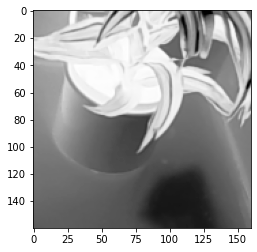

In [13]:
plt.imshow(X_test[80],cmap='Greys')

In [14]:
# Always always check shapes! 
X_train.shape, X_test.shape

((1042, 160, 160), (184, 160, 160))

In [15]:
x_train = X_train.astype("float32") / 255
x_test = X_test.astype("float32") / 255

# one hot encoder

y_train = keras.utils.to_categorical(y_train, num_classes)

y_test = keras.utils.to_categorical(y_test, num_classes)


#### ATTENTION we must have categories starting from 0 to ...



In [34]:
# define the keras model.    the kernel size is the window that checks geometries: can be (3,3), (5,5), (7,7)
# Always clear the session!
K.clear_session()
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu"),   # number of neurons:  must be multiples of 2. good technique to start eith 8 and then we increase in the insede layers.
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
# model summary table
model.summary()

# define the batch size and number of epochs
batch_size = 5
epochs = 200




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 16)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 76, 76, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 46208)             0         
                                                                 
 dropout (Dropout)           (None, 46208)             0

In [35]:
# complile and define eval metric
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



In [ ]:
# fit the model
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [ ]:
model.save("model_MNIST_3.h5")
# here you can stop your notebook
# moons_model = load_model("model_MNIST.h5")
# moons_model.summary()

In [47]:
##### Load model if needed
from tensorflow.keras.models import load_model
model = load_model("model_MNIST.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 23104)             0         
                                                                 
 dropout (Dropout)           (None, 23104)             0

In [48]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.19567352533340454
Test accuracy: 0.95652174949646


In [69]:
import time
mapping = {'plants' : 0,'coins' : 1,'faces' : 2,'cups' : 3,'glasses' : 4,'pens' : 5,'gestures' : 6,'cutlery' : 7,'plates' : 8, 
             'nail_polishes' : 9  ,'shoes' : 10 
             }
ynew = model.predict(x_test)
# show the inputs and predicted outputs
for idx, value in enumerate(ynew):
    print(f'With {np.max(value)} probability the model predicts that it is a {list(mapping)[np.where(value == np.max(value))[0][0]]}.')#
    print(f'The item is {list(mapping)[np.where(y_test[idx] == np.max(y_test[idx]))[0][0]]}.')
    # plt.imshow(X_test[idx],cmap='Greys')
    # time.sleep(8)

    


KeyboardInterrupt: 

# Train a different model

In [61]:
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow import keras

In [62]:
# folder names containing images of the things you want to classify
classes = ['plants' ,'coins' ,'faces' ,'cups','glasses' ,'pens' ,'gestures' ,'cutlery' ,'plates' , 
             'nail_polishes'  ,'shoes']
# plug in the path to your data folder
base_path ='../output/'
# define an image data generator
data_gen = image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=preprocess_input  
)
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=60,
        target_size=(224, 224)
)
# first 30 images , each time you rerun this the next set of 30 images will be displayed
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

# Transfer learning on MobileNet model
from tensorflow.keras.applications import mobilenet_v2
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

base_model.trainable = False
model = keras.Sequential() # defining a new model
model.add(base_model) # adding in the pretrained model without the fully connected layer
model.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
# have a look at the trainable and non-trainable params statistic
len(classes)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          batch_size=100, 
          callbacks=[callback],
          # use 30% of the data for validation
          validation_split=0.3)

Found 1226 images belonging to 11 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.35_224 (Funct  (None, 1280)             410208    
 ional)                                                          
                                                                 
 dense_3 (Dense)             (None, 11)                14091     
                                                                 
Total params: 424,299
Trainable params: 14,091
Non-trainable params: 410,208
_________________________________________________________________
Epoch 1/50
1/1 - 6s - loss: 3.0037 - categorical_accuracy: 0.2143 - val_loss: 2.4804 - val_categorical_accuracy: 0.1667 - 6s/epoch - 6s/step
Epoch 2/50
1/1 - 2s - loss: 2.6351 - categorical_accuracy: 0.2143 - val_loss: 2.2303 - val_categorical_accuracy: 0.2222 - 2s/epoch - 2s/step
Epoch 3/50
1/1 - 2s - loss: 2.2997 - categorical

In [63]:
model.save("model_mobilinet_v2.h5")

In [64]:
model = load_model("model_mobilinet_v2.h5")
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.311427593231201
Test accuracy: 0.21739129722118378


# Train another different model

In [1]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow import keras

In [3]:
# folder names containing images of the things you want to classify
classes = ['plants','coins' ,'faces' ,'cups','glasses' ,'pens' ,'gestures' ,'cutlery' ,'plates' , 
             'nail_polishes'  ,'shoes']
# plug in the path to your data folder
base_path ='../output/'
# define an image data generator
data_gen = image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=preprocess_input  
)
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=60,
        target_size=(224, 224)
)
# first 30 images , each time you rerun this the next set of 30 images will be displayed
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

# Transfer learning on MobileNet model
base_model = VGG16(
    weights='imagenet', 
    #alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

base_model.trainable = False
model = keras.Sequential() 
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(len(classes), activation='softmax'))
len(classes)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(xtrain, ytrain, 
          epochs=50, 
          verbose=2,
          batch_size=60, 
          callbacks=[callback],
          # use 30% of the data for validation
          validation_split=0.30)

Found 1226 images belonging to 11 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 11)                1419      
                                                                 
Total params: 14,781,771
Trainable params: 67,083
Non-trainable params: 14,714,688
____________________________________________________________

In [5]:
model.save("model_vgg16.h5")

In [7]:
model = load_model("model_vgg16.h5")
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

NameError: name 'x_test' is not defined